In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

c:\Users\jaesc2\GitHub\skforecast
0.19.0


In [2]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
from skforecast.preprocessing import RollingFeaturesClassification
from skforecast.recursive import ForecasterRecursiveClassifier

In [3]:
data = pd.read_csv(
    r"C:\Users\jaesc2\Downloads\synthetic_ts_classification.csv",
    index_col = 0,
    parse_dates=True
)
data = data.asfreq('D')
data = data.sort_index()
data['promo'] = data['promo'].astype('category')
data['dow'] = data['dow'].astype('category')

display(data.head())
print(data.index)        # verás que es un DatetimeIndex
print(data.dtypes)       # tipos de cada columna
print(data.isna().sum().sum())

,y,temp,rain,promo,dow,month_sin,month_cos
2020-01-01,mid,15.761793,0.000000,0,2,0.000000,1.000000
2020-01-02,mid,12.572055,3.045914,0,3,0.017202,0.999852
2020-01-03,peak,17.220109,0.000000,0,4,0.034398,0.999408
2020-01-04,peak,17.867255,0.000000,0,5,0.051584,0.998669
2020-01-05,low,10.809966,15.321044,0,6,0.068755,0.997634


DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14'],
              dtype='datetime64[ns]', length=1200, freq='D')
y              object
temp          float64
rain          float64
promo        category
dow          category
month_sin     float64
month_cos     float64
dtype: object
0


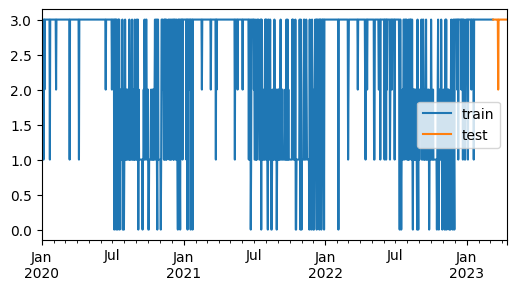

In [4]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
unique_classes = np.unique(data['y'])
n_classes = len(unique_classes)
label_encoder_ = LabelEncoder()
y_train_plot = pd.Series(label_encoder_.fit_transform(data_train['y']), index=data_train.index)
y_test_plot = pd.Series(label_encoder_.transform(data_test['y']), index=data_test.index)

fig, ax = plt.subplots(figsize=(6, 3))
y_train_plot.plot(ax=ax, label='train')
y_test_plot.plot(ax=ax, label='test')
ax.legend();

# `y` as floats -> no necesito encoding -> pero regressor LGBM -> cateogrical porque es 'auto' 

In [14]:
# Create and fit forecaster
# ==============================================================================
stats = [
    'proportion', 'mode', 'entropy', 'n_changes', 'n_unique'
]

rolling = RollingFeaturesClassification(
    stats=stats, 
    window_sizes=10,
    # features_names=[f"feature_{i}" for i in range(len(stats))]
)

forecaster = ForecasterRecursiveClassifier(
                 regressor         = LGBMClassifier(random_state=123, verbose=-1),
                 lags              = 3,
                 window_features   = rolling,
                 features_encoding = 'numeric', 
             )

X_train, y_train = forecaster.create_train_X_y(
    y=data_train['y'], exog=data_train.drop(columns=['y'])
)
forecaster.fit(
    y=data_train['y'], exog=data_train.drop(columns=['y'])
)

0.0 numeric
1.0 numeric
2.0 numeric
3.0 numeric
0.0 numeric
1.0 numeric
2.0 numeric
3.0 numeric


In [15]:
X_train

,lag_1,lag_2,lag_3,roll_proportion_10_class_0.0,roll_proportion_10_class_1.0,roll_proportion_10_class_2.0,roll_proportion_10_class_3.0,roll_mode_10,roll_entropy_10,roll_n_changes_10,roll_n_unique_10,temp,rain,promo,dow,month_sin,month_cos
2020-01-11,3.0,3.0,2.0,0.0,0.2,0.3,0.5,3.0,1.485475,5.0,3.0,18.910266,1.357976,0,5,0.171177,0.985240
2020-01-12,3.0,3.0,3.0,0.0,0.2,0.2,0.6,3.0,1.370951,5.0,3.0,18.825474,3.007783,0,6,0.188099,0.982150
2020-01-13,3.0,3.0,3.0,0.0,0.2,0.1,0.7,3.0,1.156780,4.0,3.0,17.214738,0.000000,0,0,0.204966,0.978769
2020-01-14,3.0,3.0,3.0,0.0,0.2,0.1,0.7,3.0,1.156780,4.0,3.0,20.035825,4.432135,0,1,0.221772,0.975099
2020-01-15,3.0,3.0,3.0,0.0,0.2,0.1,0.7,3.0,1.156780,3.0,3.0,18.553899,3.644224,0,2,0.238513,0.971139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-05,3.0,3.0,3.0,0.0,0.0,0.0,1.0,3.0,0.000000,0.0,1.0,20.313039,0.000000,0,6,0.885725,0.464210
2023-03-06,3.0,3.0,3.0,0.0,0.0,0.0,1.0,3.0,0.000000,0.0,1.0,20.968114,13.270779,0,0,0.893579,0.448906
2023-03-07,3.0,3.0,3.0,0.0,0.0,0.0,1.0,3.0,0.000000,0.0,1.0,23.103535,1.303960,0,1,0.901169,0.433469
2023-03-08,3.0,3.0,3.0,0.0,0.0,0.0,1.0,3.0,0.000000,0.0,1.0,23.448397,13.079436,0,2,0.908492,0.417903


In [16]:
X_train.dtypes

lag_1                            float64
lag_2                            float64
lag_3                            float64
roll_proportion_10_class_0.0     float64
roll_proportion_10_class_1.0     float64
roll_proportion_10_class_2.0     float64
roll_proportion_10_class_3.0     float64
roll_mode_10                     float64
roll_entropy_10                  float64
roll_n_changes_10                float64
roll_n_unique_10                 float64
temp                             float64
rain                             float64
promo                           category
dow                             category
month_sin                        float64
month_cos                        float64
dtype: object

In [17]:
forecaster.encoding_mapping_

{'high': 0.0, 'low': 1.0, 'mid': 2.0, 'peak': 3.0}

In [18]:
forecaster.last_window_

,y
2023-02-28,peak
2023-03-01,peak
2023-03-02,peak
2023-03-03,peak
2023-03-04,peak
2023-03-05,peak
2023-03-06,peak
2023-03-07,peak
2023-03-08,peak
2023-03-09,peak


In [62]:
(X_train['lag_1'].cat.codes == X_train['lag_1']).all()

np.True_

In [18]:
pd.Series(['air', 'car', 'bus'], dtype='category')

0    air
1    car
2    bus
dtype: category
Categories (3, object): ['air', 'bus', 'car']

In [19]:
y = pd.Series(['air', 'car', 'bus'], dtype='object')
y

0    air
1    car
2    bus
dtype: object

In [27]:
y = pd.Series(['air', 'car', 'bus'], dtype='object')
y = pd.Categorical(y, categories=['air', 'car', 'bus'])

print(y.categories)
print(y.codes)
print(y)

Index(['air', 'car', 'bus'], dtype='object')
[0 1 2]
['air', 'car', 'bus']
Categories (3, object): ['air', 'car', 'bus']


In [31]:
y = pd.Series(['bus', 'car', 'air'], dtype='object')
y = pd.Categorical(y, categories=['car', 'air', 'bus'])

print(y.categories)
print(y.codes)

Index(['car', 'air', 'bus'], dtype='object')
[2 0 1]


In [17]:
y = pd.Categorical(['bus', 'air', 'car', 'air'], ordered=False)

print(y.categories)
print(y.codes)

Index(['air', 'bus', 'car'], dtype='object')
[1 0 2 0]


In [24]:
y = pd.Series(pd.Categorical(['bus', 'air', 'car', 'air'], ordered=False))

print(y.cat.categories)
print(y.cat.codes)

Index(['air', 'bus', 'car'], dtype='object')
0    1
1    0
2    2
3    0
dtype: int8


In [25]:
from sklearn.preprocessing import OrdinalEncoder

variable_1 = pd.Series(['bus', 'air', 'car', 'air'], name='y')
encoder = OrdinalEncoder(
            categories = 'auto',
            dtype      = int
        ).set_output(transform='pandas')
variable_1_encoded = encoder.fit_transform(variable_1.to_frame())
variable_1_encoded

,y
0,1
1,0
2,2
3,0


In [26]:
encoding_mapping_ = {}
for i, code in enumerate(encoder.categories_[0]):
    encoding_mapping_[code] = i
encoding_mapping_

{'air': 0, 'bus': 1, 'car': 2}

In [27]:
encoder.categories_[0]

array(['air', 'bus', 'car'], dtype=object)

In [29]:
y = pd.Series(
        pd.Categorical(
            ['bus', 'air', 'car', 'air'], 
            ordered=False,
            categories=encoder.categories_[0]
        )
    )
y

0    bus
1    air
2    car
3    air
dtype: category
Categories (3, object): ['air', 'bus', 'car']

In [38]:
encoding_mapping_.values()

dict_values([0, 1, 2])

In [40]:
lag_1 = pd.Series(np.array([1, 0, 2]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = encoding_mapping_.values(),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[1, 0, 2]
Categories (3, int64): [0, 1, 2]
[1 0 2]
Index([0, 1, 2], dtype='int64')


In [41]:
lag_1 = pd.Series(np.array([1, 2]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = encoding_mapping_.values(),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[1, 2]
Categories (3, int64): [0, 1, 2]
[1 2]
Index([0, 1, 2], dtype='int64')


In [42]:
lag_1 = pd.Series(np.array([2, 1]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = encoding_mapping_.values(),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[2, 1]
Categories (3, int64): [0, 1, 2]
[2 1]
Index([0, 1, 2], dtype='int64')


In [43]:
lag_1 = pd.Series(np.array([2, 1]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = np.array([2, 1]),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[2, 1]
Categories (2, int64): [2, 1]
[0 1]
Index([2, 1], dtype='int64')


In [44]:
from sklearn.preprocessing import OrdinalEncoder

variable_1 = pd.Series([1.0, 0.0, 2.0], name='y')
encoder = OrdinalEncoder(
            categories = 'auto',
            dtype      = int
        ).set_output(transform='pandas')
variable_1_encoded = encoder.fit_transform(variable_1.to_frame())
variable_1_encoded

,y
0,1
1,0
2,2


In [45]:
encoding_mapping_ = {}
for i, code in enumerate(encoder.categories_[0]):
    encoding_mapping_[code] = i
encoding_mapping_

{np.float64(0.0): 0, np.float64(1.0): 1, np.float64(2.0): 2}

In [46]:
lag_1 = pd.Series(np.array([1., 0., 2.]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = encoding_mapping_.values(),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[1, 0, 2]
Categories (3, int64): [0, 1, 2]
[1 0 2]
Index([0, 1, 2], dtype='int64')


In [47]:
lag_1 = pd.Series(np.array([0., 1., 2.]))
lag_1 = pd.Categorical(
            values     = lag_1,
            categories = encoding_mapping_.values(),
            ordered    = False
        )

print(lag_1)
print(lag_1.codes)
print(lag_1.categories)

[0, 1, 2]
Categories (3, int64): [0, 1, 2]
[0 1 2]
Index([0, 1, 2], dtype='int64')


In [19]:
dict(enumerate(y.categories))

{0: 'air', 1: 'bus', 2: 'car'}

In [37]:
variable_1 = pd.Series(["a", "b", "c", "a"], dtype="category")
variable_2 = pd.Series(['b', 'c', 'b'], dtype="category")
variable_2 = pd.Series(['c', 'c', 'd'], dtype="category")

# variable_1 = pd.Series([1, 2, 1, 3], dtype="category")
# variable_2 = pd.Series(['b', 'c', 'b'], dtype="category")
# variable_2 = pd.Series([2, 3, 3], dtype="category")

variable_2 = pd.Series(pd.Categorical(
                variable_2,
                categories=variable_1.cat.categories,
                ordered=False
            ))

mapa_variable_1 = dict(enumerate(variable_1.cat.categories))
mapa_variable_2 = dict(enumerate(variable_2.cat.categories))
print(mapa_variable_1)
print(mapa_variable_2)
print(variable_2)
print(variable_2.cat.codes)

{0: 'a', 1: 'b', 2: 'c'}
{0: 'a', 1: 'b', 2: 'c'}
0      c
1      c
2    NaN
dtype: category
Categories (3, object): ['a', 'b', 'c']
0    2
1    2
2   -1
dtype: int8


In [58]:
from sklearn.preprocessing import OrdinalEncoder

variable_1 = pd.Series(["a", "b", "c", "a"], name='y')
encoder = OrdinalEncoder(
            categories = 'auto',
            dtype      = int
        ).set_output(transform='pandas')
variable_1_encoded = encoder.fit_transform(variable_1.to_frame())
variable_1_encoded

,y
0,0
1,1
2,2
3,0


In [75]:
dtype = pd.CategoricalDtype(['a', 'b'], ordered=False)

pd.Categorical.from_codes(codes=[0, 1, 0, 1], dtype=dtype)

['a', 'b', 'a', 'b']
Categories (2, object): ['a', 'b']

In [59]:
variable_1_encoded['y'] = variable_1_encoded['y'].astype('category')
variable_1_encoded

,y
0,0
1,1
2,2
3,0


In [61]:
variable_1_encoded['y'].cat.codes

0    0
1    1
2    2
3    0
dtype: int8

In [41]:
encoding_mapping_ = {}
for i, code in enumerate(encoder.categories_[0]):
    encoding_mapping_[code] = i
encoding_mapping_

{'a': 0, 'b': 1, 'c': 2}

In [52]:
encoder.categories_[0]

array(['a', 'b', 'c'], dtype=object)

In [47]:
variable_1_encoded

,y
0,0
1,1
2,2
3,0


In [54]:
pd.Categorical(
    values     = variable_1_encoded['y'],
    categories = encoding_mapping_.values(),
    ordered    = False
)

[0, 1, 2, 0]
Categories (3, int64): [0, 1, 2]

In [56]:
variable_2 = pd.Series(["b", "c", "b"], name='y')
variable_2_encoded = encoder.transform(variable_2.to_frame())
variable_2_encoded

,y
0,1
1,2
2,1


In [57]:
pd.Categorical(
    values     = variable_2_encoded['y'],
    categories = encoding_mapping_.values(),
    ordered    = False
)

[1, 2, 1]
Categories (3, int64): [0, 1, 2]

## Entradas

1. `y` as floats -> no necesito encoding -> pero regressor LGBM es auto -> transformar a categorical porque es 'auto' -> extraer los encodings como el multiseries -> crear lags -> transformar lags a categorical.

2. `y` as strings -> transformar a categorical -> extraer los encodings como el multiseries -> crear lags -> transformar lags a categorical.



In [62]:
variable_3 = pd.Series([1, 2, 1], name='y').to_frame()

In [66]:
y_cat = pd.Categorical(
    values     = variable_3['y'],
    categories = encoding_mapping_.values(),
    ordered    = False
)
y_cat

[1, 2, 1]
Categories (3, int64): [0, 1, 2]

In [12]:
pd.Categorical(
    values     = np.array([2, 3, 1]),
    ordered    = False
)

[2, 3, 1]
Categories (3, int64): [1, 2, 3]

In [13]:
pd.Categorical(
    values     = np.array([2, 3, 1]),
    ordered    = True
)

[2, 3, 1]
Categories (3, int64): [1 < 2 < 3]

In [67]:
y_cat.codes

array([1, 2, 1], dtype=int8)

In [69]:
np.testing.assert_array_equal(y_cat.codes, y_cat.to_numpy())

In [12]:
y_train

2020-01-04    3
2020-01-05    1
2020-01-06    1
2020-01-07    3
2020-01-08    2
             ..
2023-03-05    3
2023-03-06    3
2023-03-07    3
2023-03-08    3
2023-03-09    3
Freq: D, Name: y, Length: 1161, dtype: int64

In [74]:
# Print the features considered as categorical by the forecaster
# ==============================================================================
regressor = forecaster.regressor
cat_index = regressor.booster_.params.get('categorical_column')
if cat_index is not None:
    features_in_model = regressor.booster_.feature_name()
    cat_features_in_model = [features_in_model[i] for i in cat_index]
    
cat_features_in_model

['lag_1', 'lag_2', 'lag_3', 'promo', 'dow']

In [75]:
forecaster.label_encoder_.classes_

array(['high', 'low', 'mid', 'peak'], dtype=object)

In [78]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36, exog=data_test.drop(columns=['y']))
predictions.head(3)

2023-03-10    3.0
2023-03-11    3.0
2023-03-12    3.0
Freq: D, Name: pred, dtype: float64

In [78]:
y_values = np.array([1.0, 2.0, 3.0, 4.5, 5.1])
not_allowed = np.mod(y_values, 1) != 0
print(not_allowed)
if np.any(not_allowed):
    bad = y_values[not_allowed]
    examples = ", ".join(map(str, np.unique(bad)[:5]))
    raise ValueError(
        "Invalid target for classification: targets must be discrete class labels "
        "(e.g., integers or strings). Received float dtype "
        f"{y_values.dtype} with non-integer values (e.g., {examples}). "
        "If this is a regression problem, use a regression estimator instead. "
        "If labels are meant to be classes, convert them to integers or categories, "
        "e.g., `y = np.round(y).astype(int)` if values should be integers, or map "
        "the floats to class codes explicitly."
    )

[False False False  True  True]


ValueError: Invalid target for classification: targets must be discrete class labels (e.g., integers or strings). Received float dtype float64 with non-integer values (e.g., 4.5, 5.1). If this is a regression problem, use a regression estimator instead. If labels are meant to be classes, convert them to integers or categories, e.g., `y = np.round(y).astype(int)` if values should be integers, or map the floats to class codes explicitly.

In [1]:
d = {
    1.0: 'air'
}


In [2]:
d[1]

'air'

In [ ]:
1.0 -> 1

In [29]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
X = pd.DataFrame(
        pd.Categorical(
            values     = np.round(X[:, 0]).flatten(),
            categories = np.unique(np.round(X[:, 0])),
            ordered    = False
        ),
        columns = ['feature_1']
    )
clf = HistGradientBoostingClassifier(max_iter=10).fit(X, y)
clf.score(X, y)

0.6533333333333333

In [31]:
X['feature_1']

0      5.0
1      5.0
2      5.0
3      5.0
4      5.0
      ... 
145    7.0
146    6.0
147    6.0
148    6.0
149    6.0
Name: feature_1, Length: 150, dtype: category
Categories (5, float64): [4.0, 5.0, 6.0, 7.0, 8.0]

In [36]:
X_pred = pd.DataFrame(
        pd.Categorical(
            values     = np.array([9]),
            categories = np.array( [4.0, 5.0, 6.0, 7.0, 8.0]),
            ordered    = False
        ),
        columns = ['feature_1']
    )
X_pred['feature_1']

0   NaN
Name: feature_1, dtype: category
Categories (5, float64): [4.0, 5.0, 6.0, 7.0, 8.0]

In [37]:
X_pred['feature_1'].cat.codes

0   -1
dtype: int8

In [38]:
clf.predict(X_pred)

array([1])

In [26]:
pd.Series(
        pd.Categorical(
            values     = np.round(X[:, 0]).flatten(),
            categories = np.unique(np.round(X[:, 0])),
            ordered    = False
        )
    )

0      5.0
1      5.0
2      5.0
3      5.0
4      5.0
      ... 
145    7.0
146    6.0
147    6.0
148    6.0
149    6.0
Length: 150, dtype: category
Categories (5, float64): [4.0, 5.0, 6.0, 7.0, 8.0]

In [24]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [49]:
y = np.arange(1000)

In [50]:
%%timeit

not_allowed = np.mod(y, 1) != 0
if np.any(not_allowed):
    pass

7.88 μs ± 180 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [51]:
%%timeit

if np.any(y % 1 != 0):
    not_allowed = y % 1 != 0

7.93 μs ± 175 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [45]:
%%timeit

np.any(np.mod(y, 1) != 0)

31.6 μs ± 790 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [46]:
%%timeit

np.any(y % 1 != 0)

31.4 μs ± 648 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [4]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [9]:
y.astype(float)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [21]:
import pandas as pd

pd.Categorical(
    values     = np.array([0, 1, 2, np.nan]),
    categories = np.array([0, 1, 2]),
    ordered    = False
).codes

array([ 0,  1,  2, -1], dtype=int8)

In [53]:
import pandas as pd
import numpy as np
import time

# Generar datos de prueba
np.random.seed(42)
sizes = [100, 1000, 10000, 100000]
window_size = 10

print("=" * 70)
print("BENCHMARK: Cálculo de proporciones con rolling window")
print("=" * 70)

for size in sizes:
    print(f"\n{'=' * 70}")
    print(f"Tamaño de datos: {size:,} elementos")
    print(f"Ventana: {window_size}")
    print("=" * 70)
    
    # Crear serie con valores 1, 2, 3
    s = pd.Series(np.random.choice([1, 2, 3], size=size))
    
    # ===== OPCIÓN 1: apply() con lambda =====
    print("\n[Opción 1] Rolling apply con lambda (menos eficiente)")
    start = time.time()
    
    df1 = pd.DataFrame({
        'prop_1': s.rolling(window_size).apply(lambda x: (x == 1).sum() / len(x), raw=True),
        'prop_2': s.rolling(window_size).apply(lambda x: (x == 2).sum() / len(x), raw=True),
        'prop_3': s.rolling(window_size).apply(lambda x: (x == 3).sum() / len(x), raw=True)
    })
    
    time1 = time.time() - start
    print(f"  Tiempo: {time1:.4f} segundos")
    
    # ===== OPCIÓN 2: get_dummies + rolling =====
    print("\n[Opción 2] get_dummies + rolling (más eficiente)")
    start = time.time()
    
    dummies = pd.get_dummies(s, prefix='class')
    proportions = dummies.rolling(window=window_size).sum() / window_size
    df2 = proportions.copy()
    df2.columns = ['prop_1', 'prop_2', 'prop_3']
    
    time2 = time.time() - start
    print(f"  Tiempo: {time2:.4f} segundos")
    
    # Comparación
    speedup = time1 / time2
    print(f"\n{'🚀 RESULTADO':}")
    print(f"  Opción 2 es {speedup:.2f}x más rápida")
    print(f"  Ahorro de tiempo: {(time1 - time2):.4f} segundos")
    
    # Verificar que dan el mismo resultado
    assert np.allclose(df1.dropna(), df2.dropna(), rtol=1e-10), "Los resultados no coinciden!"
    print(f"  ✓ Ambos métodos producen resultados idénticos")
    
    # Mostrar muestra de resultados
    print(f"\n  Muestra de resultados (últimas 5 filas):")
    print(df2.tail().to_string(index=False))

print("\n" + "=" * 70)
print("CONCLUSIÓN:")
print("La Opción 2 (get_dummies + rolling) es significativamente más rápida")
print("porque usa operaciones vectorizadas en lugar de aplicar funciones Python")
print("=" * 70)

BENCHMARK: Cálculo de proporciones con rolling window

Tamaño de datos: 100 elementos
Ventana: 10

[Opción 1] Rolling apply con lambda (menos eficiente)
  Tiempo: 0.0010 segundos

[Opción 2] get_dummies + rolling (más eficiente)
  Tiempo: 0.0020 segundos

🚀 RESULTADO
  Opción 2 es 0.50x más rápida
  Ahorro de tiempo: -0.0010 segundos
  ✓ Ambos métodos producen resultados idénticos

  Muestra de resultados (últimas 5 filas):
 prop_1  prop_2  prop_3
    0.7     0.1     0.2
    0.8     0.1     0.1
    0.7     0.1     0.2
    0.8     0.0     0.2
    0.8     0.0     0.2

Tamaño de datos: 1,000 elementos
Ventana: 10

[Opción 1] Rolling apply con lambda (menos eficiente)
  Tiempo: 0.0100 segundos

[Opción 2] get_dummies + rolling (más eficiente)
  Tiempo: 0.0010 segundos

🚀 RESULTADO
  Opción 2 es 10.09x más rápida
  Ahorro de tiempo: 0.0090 segundos
  ✓ Ambos métodos producen resultados idénticos

  Muestra de resultados (últimas 5 filas):
 prop_1  prop_2  prop_3
    0.5     0.3     0.2
    

In [61]:
from numba import njit, jit

@njit
def _mode_jit(x):
    n = x.size
    if n == 0:
        return np.nan

    xs = np.sort(x.copy())

    # Si es float, ignoramos NaN (que quedan al final tras ordenar)
    valid_n = n
    if xs.dtype == np.float64 or xs.dtype == np.float32:
        k = n - 1
        while k >= 0 and np.isnan(xs[k]):
            k -= 1
        valid_n = k + 1
        if valid_n == 0:
            return np.nan

    best_val = xs[0]
    best_count = 1
    curr_val = xs[0]
    curr_count = 1

    for i in range(1, valid_n):
        if xs[i] == curr_val:
            curr_count += 1
        else:
            if curr_count > best_count:
                best_count = curr_count
                best_val = curr_val
            curr_val = xs[i]
            curr_count = 1

    # Última racha
    if curr_count > best_count:
        best_val = curr_val

    return best_val

In [ ]:
_mode_jit(np.array([1, 1, 2, 2, 2, 3]))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function eq>) found for signature:
 
 >>> eq(dtype(int64), class(float64))
 
There are 34 candidate implementations:
[1m      - Of which 30 did not match due to:
      Overload of function 'eq': File: <numerous>: Line N/A.
        With argument(s): '(dtype(int64), class(float64))':[0m
[1m       No match.[0m
[1m      - Of which 2 did not match due to:
      Operator Overload in function 'eq': File: unknown: Line unknown.
        With argument(s): '(dtype(int64), class(float64))':[0m
[1m       No match for registered cases:
        * (bool, bool) -> bool
        * (int8, int8) -> bool
        * (int16, int16) -> bool
        * (int32, int32) -> bool
        * (int64, int64) -> bool
        * (uint8, uint8) -> bool
        * (uint16, uint16) -> bool
        * (uint32, uint32) -> bool
        * (uint64, uint64) -> bool
        * (float32, float32) -> bool
        * (float64, float64) -> bool
        * (complex64, complex64) -> bool
        * (complex128, complex128) -> bool[0m
[1m      - Of which 2 did not match due to:
      Overload in function 'set_eq': File: numba\cpython\setobj.py: Line 1653.
        With argument(s): '(dtype(int64), class(float64))':[0m
[1m       Rejected as the implementation raised a specific error:
         TypingError: [1mAll arguments must be Sets, got (dtype(int64), class(float64))[0m[0m
  raised from c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\numba\cpython\setobj.py:108
[0m
[0m[1mDuring: typing of intrinsic-call at C:\Users\jaesc2\AppData\Local\Temp\ipykernel_32172\532006454.py (13)[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_32172\532006454.py", line 13:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m

In [ ]:
rolling_obj.apply(lambda x: _mode_jit(x.to_numpy()), raw=False)

In [64]:
@jit(nopython=True)
def _n_unique_jit(x):
    """Count number of unique classes using numba JIT."""
    return len(np.unique(x))

_n_unique_jit(np.array([1, 2, 2, 3, 1, 4, 4]))

4

In [ ]:
@jit(nopython=True)
def _n_changes_jit(x):
    """Count number of class changes using numba JIT."""
    if len(x) <= 1:
        return 0
    changes = 0
    for i in range(1, len(x)):
        if x[i] != x[i-1]:
            changes += 1
    return changes

_n_changes_jit(np.array([1, 2, 2, 3, 1, 4, 4]))

4

In [81]:
from scipy.stats import entropy as scipy_entropy

def _entropy_jit(x):
    """Calculate entropy of class distribution."""
    if len(x) == 0:
        return np.nan
    _, counts = np.unique(x, return_counts=True)
    probabilities = counts / len(x)
    return scipy_entropy(probabilities, base=2)

import numpy as np
from numba import njit

@njit
def entropy_bits_numba(x):
    n = x.size
    if n == 0:
        return np.nan

    # Copia y ordena
    xs = np.sort(x.copy())

    # Si es float, ignoramos NaN al final (tras ordenar)
    valid_n = n
    if xs.dtype == np.float64 or xs.dtype == np.float32:
        # Cuenta NaN desde el final
        k = n - 1
        while k >= 0 and np.isnan(xs[k]):
            k -= 1
        valid_n = k + 1
        if valid_n == 0:
            return np.nan

    # Run-length + entropía sin almacenar counts
    H = 0.0
    total = valid_n
    curr = xs[0]
    count = 1

    for i in range(1, valid_n):
        if xs[i] == curr:
            count += 1
        else:
            p = count / total
            H -= p * (np.log(p) / np.log(2.0))  # log2
            curr = xs[i]
            count = 1

    # Última racha
    p = count / total
    H -= p * (np.log(p) / np.log(2.0))
    return H


_entropy_jit(np.array([1, 2, 2, 3, 1, 4, 4]))
entropy_bits_numba(np.array([1, 2, 2, 3, 1, 4, 4]))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function eq>) found for signature:
 
 >>> eq(dtype(int64), class(float64))
 
There are 34 candidate implementations:
[1m      - Of which 30 did not match due to:
      Overload of function 'eq': File: <numerous>: Line N/A.
        With argument(s): '(dtype(int64), class(float64))':[0m
[1m       No match.[0m
[1m      - Of which 2 did not match due to:
      Operator Overload in function 'eq': File: unknown: Line unknown.
        With argument(s): '(dtype(int64), class(float64))':[0m
[1m       No match for registered cases:
        * (bool, bool) -> bool
        * (int8, int8) -> bool
        * (int16, int16) -> bool
        * (int32, int32) -> bool
        * (int64, int64) -> bool
        * (uint8, uint8) -> bool
        * (uint16, uint16) -> bool
        * (uint32, uint32) -> bool
        * (uint64, uint64) -> bool
        * (float32, float32) -> bool
        * (float64, float64) -> bool
        * (complex64, complex64) -> bool
        * (complex128, complex128) -> bool[0m
[1m      - Of which 2 did not match due to:
      Overload in function 'set_eq': File: numba\cpython\setobj.py: Line 1653.
        With argument(s): '(dtype(int64), class(float64))':[0m
[1m       Rejected as the implementation raised a specific error:
         TypingError: [1mAll arguments must be Sets, got (dtype(int64), class(float64))[0m[0m
  raised from c:\Users\jaesc2\Miniconda3\envs\skforecast_py12\Lib\site-packages\numba\cpython\setobj.py:108
[0m
[0m[1mDuring: typing of intrinsic-call at C:\Users\jaesc2\AppData\Local\Temp\ipykernel_32172\1528066423.py (25)[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_32172\1528066423.py", line 25:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m

In [80]:
x = pd.Series(np.arange(10000), name='y')
rolling_obj = x.rolling(window=10)
rolling_obj.apply(lambda x: _n_unique_jit(x), raw=True)
rolling_obj.apply(lambda x: _n_changes_jit(x), raw=True)
rolling_obj.apply(lambda x: _entropy_jit(x), raw=True)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
9995    3.321928
9996    3.321928
9997    3.321928
9998    3.321928
9999    3.321928
Name: y, Length: 10000, dtype: float64

In [73]:
%%timeit

rolling_obj.apply(lambda x: _n_changes_jit(x.to_numpy()), raw=False)

125 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
%%timeit

rolling_obj.apply(lambda x: _n_changes_jit(x), raw=True)

5.01 ms ± 63.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
a = rolling_obj.apply(lambda x: _n_changes_jit(x.to_numpy()), raw=False)
b = rolling_obj.apply(lambda x: _n_changes_jit(x), raw=True)

np.testing.assert_array_equal(a, b)

In [101]:
x = pd.Series(np.arange(10000), name='y')
rolling_obj = x.rolling(**{
                        'window': 10, 
                        'min_periods': 5, 
                        'center': False,
                        'closed': 'left'
                    })
print(rolling_obj.window)
print(rolling_obj.min_periods)
print(rolling_obj.closed)
print(rolling_obj.center)

10
5
left
False


In [ ]:
import numpy as np
from numba import njit

@jit(nonpython=False)
@njit
def mode_numba(x):
    n = x.size
    if n == 0:
        return np.nan

    xs = x.astype(np.float64)       # <-- forzamos float
    xs = np.sort(xs)

    # Ignorar NaN (quedan al final tras ordenar)
    valid_n = n
    k = n - 1
    while k >= 0 and np.isnan(xs[k]):
        k -= 1
    valid_n = k + 1
    if valid_n == 0:
        return np.nan

    best_val = xs[0]
    best_count = 1
    curr_val = xs[0]
    curr_count = 1

    for i in range(1, valid_n):
        if xs[i] == curr_val:
            curr_count += 1
        else:
            if curr_count > best_count:
                best_count = curr_count
                best_val = curr_val
            curr_val = xs[i]
            curr_count = 1

    # Última racha
    if curr_count > best_count:
        best_val = curr_val

    return best_val  # siempre float64

mode_numba(np.array([1, 1, 2, 2, 2, 3, np.nan]))

2.0

In [14]:
import numpy as np
from scipy import stats

a = np.array([1, 1, 2, 2, 3, np.nan])
m = stats.mode(a)[0]
print(m)

1.0


In [88]:
a = np.random.choice([1, 2, 3, 4, 5], size=1000000)

In [89]:
%%timeit

mode_numba(a)

30.8 ms ± 426 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [90]:
%%timeit

stats.mode(a)[0]

3.36 ms ± 150 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [95]:
X = pd.Series(np.array([2, 1, 3, 4, 5]), name='y')
X = pd.Series(np.array(['b', 'a', 'c']), name='y')
pd.get_dummies(X, prefix='class')

,class_a,class_b,class_c
0,False,True,False
1,True,False,False
2,False,False,True


In [4]:
import re
import pytest
import numpy as np
import pandas as pd
from skforecast.preprocessing import RollingFeaturesClassification

In [15]:
X = pd.Series(np.random.choice([1, 2, 3], size=100), name='y')
stats = [
    'proportion', 'mode', 'entropy', 'n_changes', 'n_unique'
]
    
rolling = RollingFeaturesClassification(stats=stats, window_sizes=10)
rolling_features = rolling.transform_batch(X).head(10)
rolling_features

[1 2 3]
['roll_proportion_10_class_1', 'roll_proportion_10_class_2', 'roll_proportion_10_class_3', 'roll_mode_10', 'roll_entropy_10', 'roll_n_changes_10', 'roll_n_unique_10']


,roll_proportion_10_class_1,roll_proportion_10_class_2,roll_proportion_10_class_3,roll_mode_10,roll_entropy_10,roll_n_changes_10,roll_n_unique_10
10,0.5,0.5,0.0,1.0,1.000000,3.0,2.0
11,0.4,0.5,0.1,2.0,1.360964,3.0,3.0
12,0.4,0.4,0.2,1.0,1.521928,3.0,3.0
13,0.4,0.3,0.3,1.0,1.570951,3.0,3.0
14,0.4,0.3,0.3,1.0,1.570951,4.0,3.0
15,0.5,0.2,0.3,1.0,1.485475,4.0,3.0
16,0.5,0.2,0.3,1.0,1.485475,4.0,3.0
17,0.4,0.2,0.4,1.0,1.521928,5.0,3.0
18,0.4,0.2,0.4,1.0,1.521928,6.0,3.0
19,0.4,0.2,0.4,1.0,1.521928,5.0,3.0


In [9]:
X = pd.Series(np.array([2, 1, 2, 3, 1, 2, 3, 1, 2, 3]), name='y')
X = pd.Series(np.array([1, 2, 3, 2, 2, 3, 1, 2, 3, 1, 2, 3]), name='y')
stats = [
    'proportion', 'proportion', 
]
window_sizes = [
    6, 3
]

rolling = RollingFeaturesClassification(
    stats=stats, 
    window_sizes=window_sizes,
    # features_names=[f"feature_{i}" for i in range(len(stats))]
)
rolling_features = rolling.transform_batch(X).head(10)
rolling_features

,roll_proportion_6_class_1,roll_proportion_6_class_2,roll_proportion_6_class_3,roll_proportion_3_class_1,roll_proportion_3_class_2,roll_proportion_3_class_3
6,0.166667,0.500000,0.333333,0.000000,0.666667,0.333333
7,0.166667,0.500000,0.333333,0.333333,0.333333,0.333333
8,0.166667,0.500000,0.333333,0.333333,0.333333,0.333333
9,0.166667,0.500000,0.333333,0.333333,0.333333,0.333333
10,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
11,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


In [28]:
%%timeit

sorted(np.array([2,1 ,3]))

1.81 μs ± 183 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [29]:
%%timeit

np.sort(np.array([2,1 ,3]))

1.96 μs ± 123 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [14]:
X.to_numpy()[-10:]

array([1, 1, 2, 3, 3, 2, 3, 1, 3, 1])

In [19]:
rolling_features = rolling.transform(X.to_numpy()[-10:])
rolling_features

proportion
mode
entropy
n_changes
n_unique


array([0.4       , 0.2       , 0.4       , 1.        , 1.52192809,
       7.        , 3.        ])

In [18]:
from scipy.stats import mode as scipy_mode
scipy_mode(X.to_numpy()[-10:])

ModeResult(mode=np.int64(1), count=np.int64(4))